## **1. Importación de librerias y datos**

In [33]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [34]:
df_unificado = pd.read_excel('DatosCacao_multivariado.xlsx')
df_total = df_unificado.copy()

train_size = int(len(df_unificado) * 0.8)
test_size = len(df_unificado) - train_size

df_unificado = df_unificado.iloc[:-test_size]
df_unificado.drop(columns=["Fecha"], inplace=True)

print(df_unificado.tail())

     COP/kg      TRM  COP/kg (internacional)  Inflacion  COP/kg (futuro)  \
59  23462.8  4116.80                34433.20       5.09         34334.11   
60  22958.2  4102.67                32237.84       5.09         32132.11   
61  23730.8  4168.82                33537.57       5.09         33443.65   
62  23407.5  4192.57                33168.13       5.09         33199.58   
63  23842.2  4274.03                33146.43       5.16         33932.93   

     Produccion  
59  4485.554779  
60  4485.554779  
61  4485.554779  
62  4485.554779  
63  3731.890261  


Debido a que las series no son estacionarias, se hace una diferenciación para volverlas **estacionarias** (como lo pide el modelo VAR).

In [35]:
# REVISAR ESTACIONARIEDAD

df_diff = df_unificado.diff().dropna()
df_diff.head()

,COP/kg,TRM,COP/kg (internacional),Inflacion,COP/kg (futuro),Produccion
2,-137.0,-11.55,1010.36,0.00,995.51,0.000000
3,242.9,15.01,807.33,0.00,852.67,0.000000
4,201.6,8.87,540.05,0.00,670.78,0.000000
5,235.0,2.85,1661.87,-0.61,1617.31,802.857805
6,604.0,-2.03,2233.24,0.00,2033.85,0.000000


In [36]:
from statsmodels.tsa.stattools import adfuller, kpss

def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]  # p-value

def kpss_test(series):
    result = kpss(series.dropna(), regression='c', nlags="auto")
    return result[1]  # p-value

def estacionaridad_tests(df):
    resultados = []
    for col in df.columns:
        try:
            adf_p = adf_test(df[col])
            kpss_p = kpss_test(df[col])
            
            if adf_p < 0.05 and kpss_p > 0.05:
                conclusion = "Estacionaria"
            elif adf_p > 0.05 and kpss_p < 0.05:
                conclusion = "No estacionaria"
            else:
                conclusion = "Inconcluso / revisar"
            
            resultados.append({
                "Variable": col,
                "ADF p-value": round(adf_p, 4),
                "KPSS p-value": round(kpss_p, 4),
                "Conclusión": conclusion
            })
        except Exception as e:
            resultados.append({
                "Variable": col,
                "ADF p-value": None,
                "KPSS p-value": None,
                "Conclusión": f"Error: {e}"
            })
    
    return pd.DataFrame(resultados)


resultados_est = estacionaridad_tests(df_diff)
print(resultados_est)


                 Variable  ADF p-value  KPSS p-value    Conclusión
0                  COP/kg          0.0           0.1  Estacionaria
1                     TRM          0.0           0.1  Estacionaria
2  COP/kg (internacional)          0.0           0.1  Estacionaria
3               Inflacion          0.0           0.1  Estacionaria
4         COP/kg (futuro)          0.0           0.1  Estacionaria
5              Produccion          0.0           0.1  Estacionaria


C:\Users\peter\AppData\Local\Temp\ipykernel_19988\3687467595.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_19988\3687467595.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_19988\3687467595.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression='c', nlags="auto")
C:\Users\peter\AppData\Local\Temp\ipykernel_19988\3687467595.py:8: InterpolationWarning: The test statistic i

## **2. Aplicación del modelo a los datos**

In [37]:
# Crear el modelo VAR
model = VAR(df_diff)

# Selección del rezago óptimo (AIC, BIC, HQIC, FPE)
lag_order_results = model.select_order(maxlags=5)
print(lag_order_results.summary())

# Elegir el rezago con AIC mínimo para este caso
if lag_order_results.aic < 1 or lag_order_results.aic is None:
    best_lag = 1
else:
    best_lag = lag_order_results.aic
    
print(f"Mejor rezago según AIC: {best_lag}")

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      61.15*      61.37*  3.614e+26*      61.24*
1       61.16       62.67   3.681e+26       61.75
2       61.34       64.13   4.570e+26       62.42
3       61.47       65.55   5.808e+26       63.06
4       61.51       66.89   7.570e+26       63.60
5       61.29       67.96   9.160e+26       63.88
-------------------------------------------------
Mejor rezago según AIC: 1


c:\Users\peter\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [38]:
var_model = model.fit(best_lag)
print(var_model.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 12, Oct, 2025
Time:                     22:18:40
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    62.4244
Nobs:                     61.0000    HQIC:                   61.5406
Log likelihood:          -2336.95    FPE:                3.03390e+26
AIC:                      60.9710    Det(Omega_mle):     1.58098e+26
--------------------------------------------------------------------
Results for equation COP/kg
                               coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------
const                            91.460644       271.496330            0.337           0.736
L1.COP/kg                        -0.002410         0.163668           -0.015           0.988
L1.TRM     

In [39]:
print(df_diff.shape)
print(best_lag, type(best_lag))
print(var_model.k_ar, getattr(var_model,'coefs', None))

(62, 6)
1 <class 'int'>
1 [[[-2.41001204e-03 -7.69499328e+00  5.39031851e-01 -7.48622868e+02
   -3.02708809e-01  2.29457707e-01]
  [ 5.14067281e-03 -1.75797046e-02  3.31246084e-02  8.17928809e+01
   -3.63913484e-02  1.26354884e-02]
  [-4.44259768e-02 -9.26228217e+00 -4.95853912e-02 -3.09089963e+03
    1.59026069e-01  4.46267692e-01]
  [-4.89783710e-06 -1.00684628e-04  2.26262028e-05 -1.27172875e-01
   -1.55279808e-05 -1.88447297e-06]
  [-1.10670578e-01 -8.88439879e+00  1.90028994e-01 -3.08511862e+03
   -1.15852319e-01  4.06948082e-01]
  [-1.14681283e-01  3.66044380e+00  2.32471118e-01  3.93168612e+02
   -1.45920534e-01  3.12875291e-02]]]


### Revisión de residuos y autocorrelación por variable

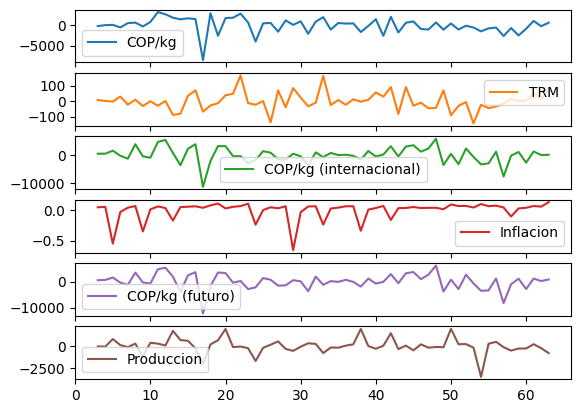

In [ ]:
residuos_var = var_model.resid
residuos_var.plot(subplots=True, layout=(len(residuos_var.columns),1))
plt.show()

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

#for col in residuos_var.columns:
#    plot_acf(residuos_var[col])
#    plot_pacf(residuos_var[col])
#plt.show()

for col in residuos_var.columns:
    lb_test_var = acorr_ljungbox(residuos_var[col], lags=[10], return_df=True)
    print(f"Ljung-Box para {col}:\n", lb_test_var)

Ljung-Box para COP/kg:
       lb_stat  lb_pvalue
10  16.053853   0.098101
Ljung-Box para TRM:
      lb_stat  lb_pvalue
10  5.157773   0.880392
Ljung-Box para COP/kg (internacional):
       lb_stat  lb_pvalue
10  10.133112   0.428894
Ljung-Box para Inflacion:
       lb_stat  lb_pvalue
10  19.874718    0.03046
Ljung-Box para COP/kg (futuro):
      lb_stat  lb_pvalue
10  9.283853   0.505393
Ljung-Box para Produccion:
       lb_stat  lb_pvalue
10  10.675655   0.383339


1. Prueba de autocorrelación (Ljung-Box, ACF/PACF):  
Se usa para detectar dependencia temporal residual no modelada.  
Si p-valor > 0.05: no se rechaza independencia, residuos adecuados.  
Si p-valor ≤ 0.05: hay autocorrelación, revisar parámetros.  

2. Pruebas de normalidad (Shapiro-Wilk, Jarque-Bera):  
Verifica si residuos siguen distribución normal (supuesto común en modelos clásicos).  
Si p-valor > 0.05: no se rechaza normalidad, validando supuestos.  
Si p-valor ≤ 0.05: residuos no normales, considerar transformaciones sobre COP/kg o métodos robustos (modelos no lineales como LSTM o XGBoost).  

In [40]:
# Número de pasos a predecir
n_steps = test_size

forecast = var_model.forecast(df_diff.values[-best_lag:], steps=n_steps)
forecast = scaler.inverse_transform(forecast)
forecast_df = pd.DataFrame(forecast, 
                           index=pd.date_range(start=df_diff.index[-1], periods=n_steps+1, freq="W")[1:], 
                           columns=df_diff.columns)

print(forecast_df.head())

                                   COP/kg        TRM  COP/kg (internacional)  \
1970-01-11 00:00:00.000000063 -995.447370 -19.501358            -1091.725685   
1970-01-18 00:00:00.000000063  122.940003   8.953546              531.862619   
1970-01-25 00:00:00.000000063  114.692448  -1.307155              224.027225   
1970-02-01 00:00:00.000000063  204.003540   7.476892              311.373761   
1970-02-08 00:00:00.000000063  129.335806   5.155671              221.338145   

                               Inflacion  COP/kg (futuro)  Produccion  
1970-01-11 00:00:00.000000063  -0.089509     -1230.039383  122.636182  
1970-01-18 00:00:00.000000063  -0.047429       698.058680  -80.464136  
1970-01-25 00:00:00.000000063  -0.053944       194.160515    1.713916  
1970-02-01 00:00:00.000000063  -0.051338       339.656112  -32.923158  
1970-02-08 00:00:00.000000063  -0.053209       229.336340  -11.996096  


In [41]:
# Tomamos el último valor real en niveles
last_obs = df_unificado.iloc[-1]

# Reconstruimos los niveles sumando acumulativamente las diferencias
forecast_levels = forecast_df.cumsum() + last_obs.values

forecast_levels = pd.DataFrame(forecast_levels, 
                               index=forecast_df.index, 
                               columns=df_unificado.columns)

print(forecast_levels.head())

                                     COP/kg          TRM  \
1970-01-11 00:00:00.000000063  22846.752630  4254.528642   
1970-01-18 00:00:00.000000063  22969.692632  4263.482188   
1970-01-25 00:00:00.000000063  23084.385081  4262.175033   
1970-02-01 00:00:00.000000063  23288.388621  4269.651925   
1970-02-08 00:00:00.000000063  23417.724426  4274.807596   

                               COP/kg (internacional)  Inflacion  \
1970-01-11 00:00:00.000000063            32054.704315   5.070491   
1970-01-18 00:00:00.000000063            32586.566934   5.023062   
1970-01-25 00:00:00.000000063            32810.594159   4.969118   
1970-02-01 00:00:00.000000063            33121.967920   4.917780   
1970-02-08 00:00:00.000000063            33343.306065   4.864572   

                               COP/kg (futuro)   Produccion  
1970-01-11 00:00:00.000000063     32702.890617  3854.526443  
1970-01-18 00:00:00.000000063     33400.949298  3774.062307  
1970-01-25 00:00:00.000000063     33595.1098

In [42]:
# Calcular métricas de error
mae = mean_absolute_error(df_total['COP/kg'].iloc[-test_size:], forecast_levels['COP/kg'])
rmse = np.sqrt(mean_squared_error(df_total['COP/kg'].iloc[-test_size:], forecast_levels['COP/kg']))

print(f'MAE: {mae:.4f}')
print(f'RMSE: {rmse:.4f}')

MAE: 3539.7394
RMSE: 4162.6985


## **3. Visualización de los resultados del forecast**

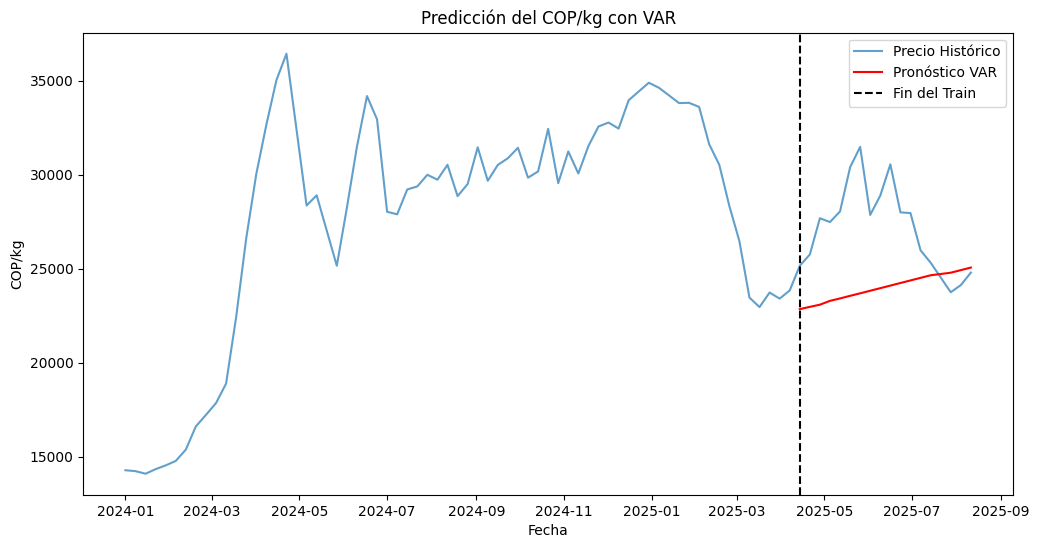

In [43]:
forecast_index = df_total['Fecha'].iloc[train_size:].reset_index(drop=True)
forecast_levels.index = pd.to_datetime(forecast_index)
train_dates = df_total['Fecha'].iloc[:train_size].reset_index(drop=True)

var_name = "COP/kg"  # variable de interés


plt.figure(figsize=(12,6))


plt.plot(df_total['Fecha'], df_total[var_name], label="Precio Histórico", color='C0', alpha=0.7)
plt.plot(forecast_levels.index, forecast_levels[var_name], label="Pronóstico VAR", color="red")
plt.axvline(df_total['Fecha'].iloc[-test_size], color='k', linestyle='--', label='Fin del Train')

plt.title(f"Predicción del {var_name} con VAR")
plt.xlabel("Fecha")
plt.ylabel(var_name)
plt.legend()
plt.show()


## **4. Análisis de impulso-respuesta (IRF)**

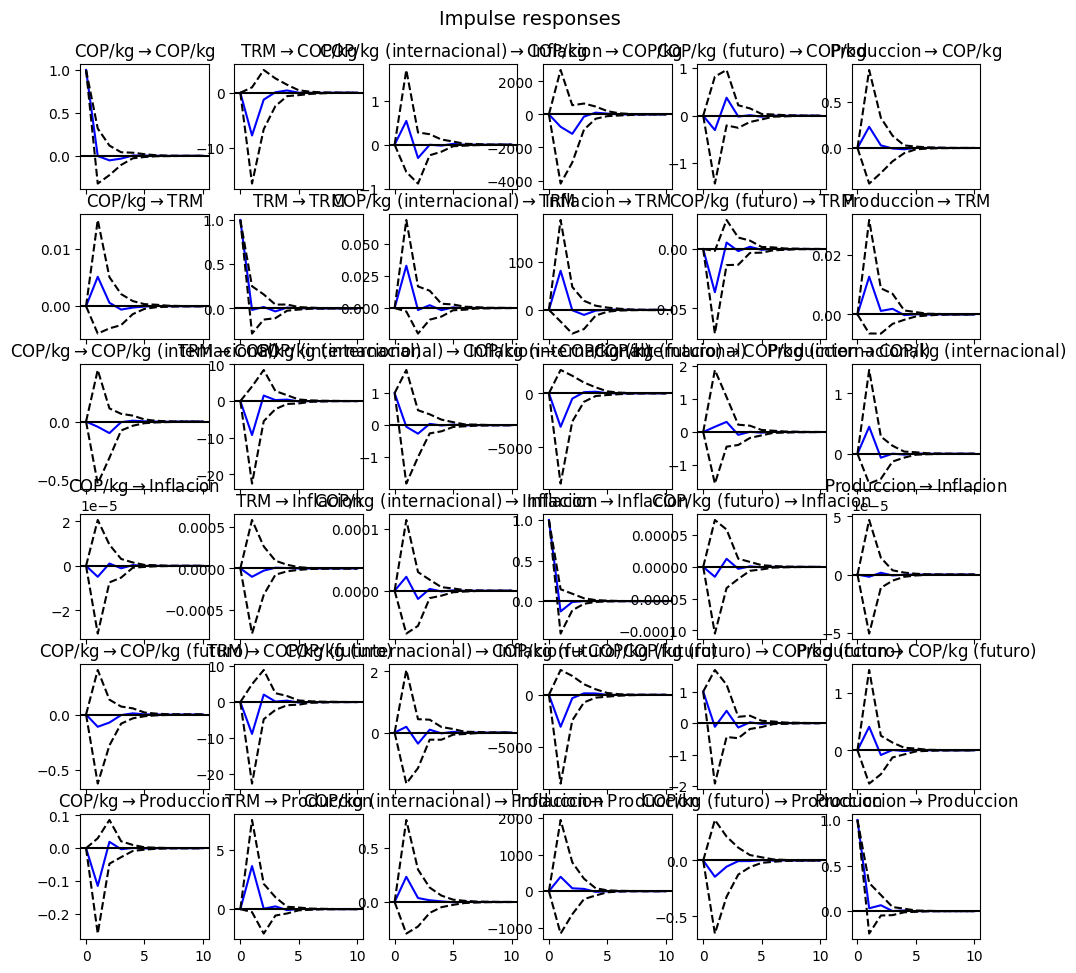

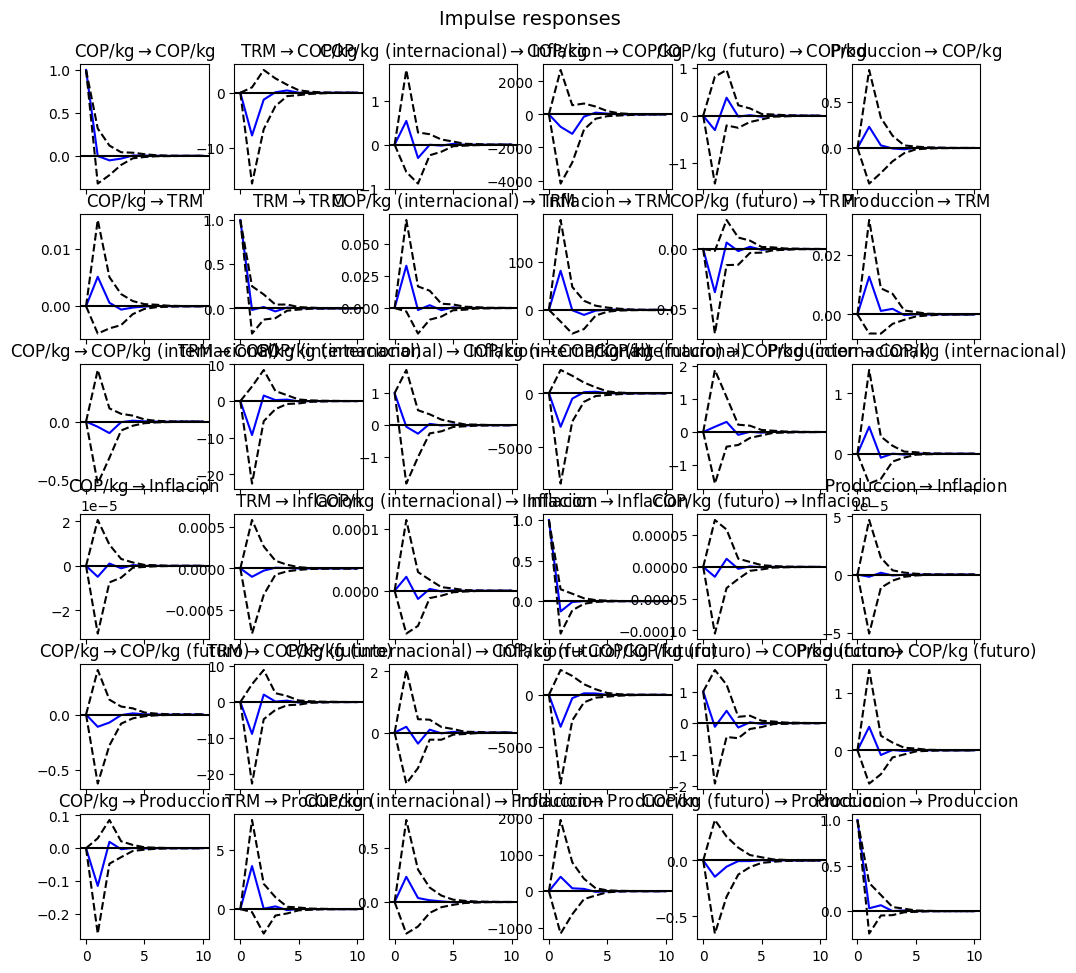

In [44]:
# Horizonte de predicción del shock
irf = var_model.irf(10)

# Graficar respuesta de todas las variables
irf.plot(orth=False)

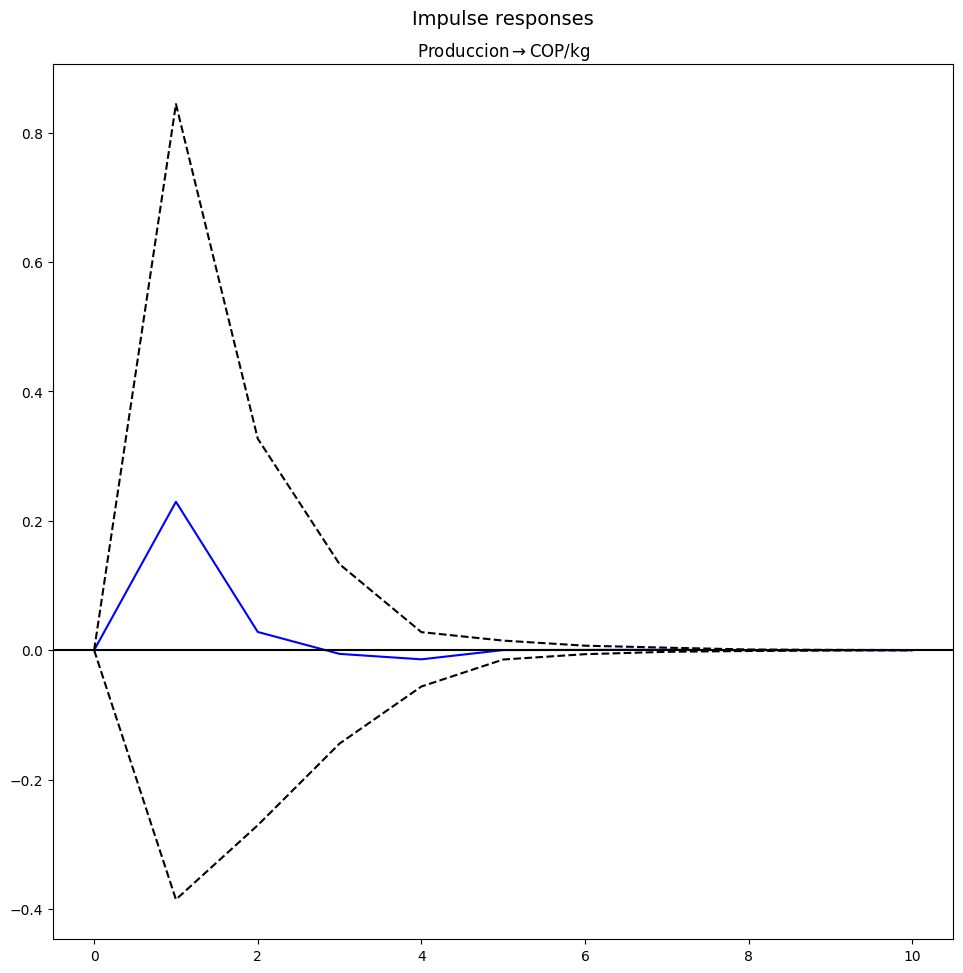

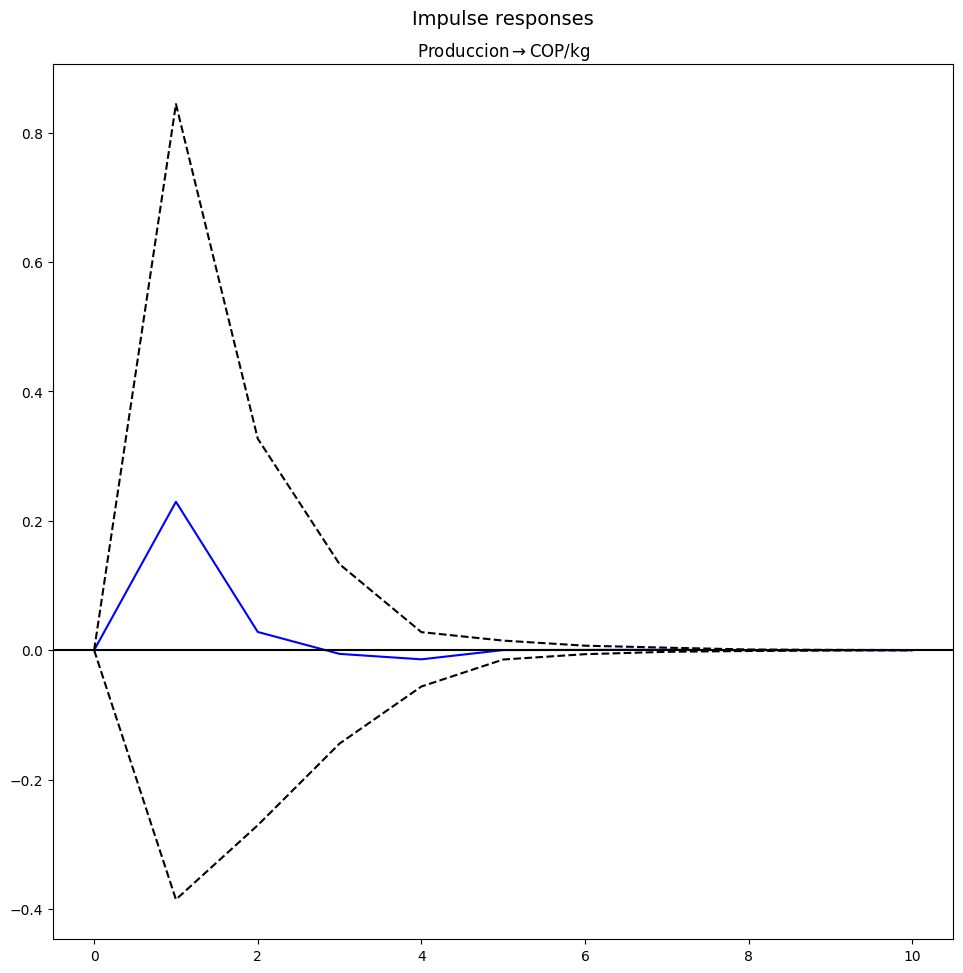

In [45]:
target = "COP/kg"   # variable de interés
shock = "Produccion"  # variable que genera el shock

irf.plot(response=target, impulse=shock, orth=False)